In [1]:
# ! pip install tensorflow
# ! pip install matplotlib

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
import time
import random

# Import and pre-processing

In [3]:
NUM_WORDS = 5000
max_review_length = 100
INDEX_FROM = 3

# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X, y), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X[1000] ))

# --- filter sequences with at least 170 words
TOTAL_LENGTH = 170
X = [lst for lst in X if len(lst) >= TOTAL_LENGTH]
# --- truncate input sequences
X = sequence.pad_sequences(X, maxlen=TOTAL_LENGTH, truncating='post')
# --- Keep only 200 sequences
N = 200
X = X[:N]

print("X shape:", X.shape)
print("len(X[0]):", len(X[0]))
print("len(X[1]):", len(X[1]))
print("X[0]:", X[0])

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

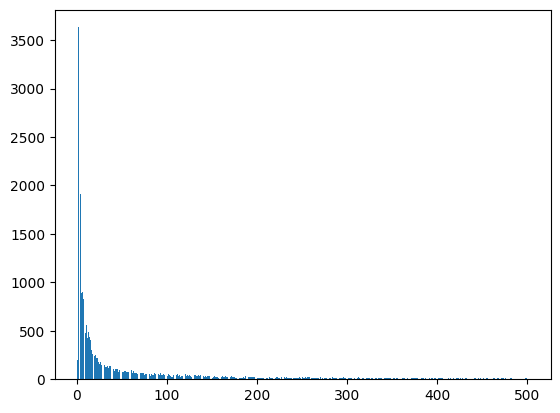

In [4]:
unique_elements, counts = np.unique(X, return_counts=True)
occurrences_dict = dict(zip(unique_elements, counts))

keys = list(occurrences_dict.keys())[:500]
values = list(occurrences_dict.values())[:500]

plt.bar(keys, values)
plt.show()

In [5]:
# Train - test split
LENGTH_TRAIN = 100
X_train = X[:, :LENGTH_TRAIN]
X_test = X[:, LENGTH_TRAIN:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (200, 100)
X_test shape: (200, 70)


# LSTM

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, topics, model_length):
        self.topics=topics
        self.model_length=model_length

    def __len__(self):
        return len(self.topics)-self.model_length

    def __getitem__(self, index):
        input_sequence=torch.tensor(self.topics[index:index+self.model_length, :])
        target_sequence=torch.tensor(self.topics[index+1:index+self.model_length+1, :])

        return input_sequence, target_sequence

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_length, batch_size):
        super(LSTM, self).__init__()
        self.input_size = input_size #input size (NUM_TOPICS)
        self.hidden_size = hidden_size #number of hidden neurons
        self.output_size = output_size #output size (NUM_TOPICS)
        self.model_length = model_length
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, prev_state):
        output, state = self.lstm(x, prev_state)
        output = self.dropout(output)
        output=self.fc(output)
        return output, state

    def init_state(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size), #(NUM_LAYERS, BATCH SIZE, NUM_NEURONES)
                torch.zeros(1, self.batch_size, self.hidden_size))

    def train_model(self, dataset, optimizer, criterion):
        self.train()
        state_h, state_c = self.init_state()
        lst_output=[]
        lst_y_true=[]
        optimizer.zero_grad()

        for t, (x, y) in enumerate(dataset):
            output , (state_h, state_c) = self.forward(x, (state_h, state_c))
            state_h = state_h.detach()
            state_c = state_c.detach()
            lst_output.append(output[:, -1, :])
            lst_y_true.append(y[:, -1, :])
        torch_output = torch.stack(lst_output).view(-1, self.output_size)  
        torch_y_true = torch.stack(lst_y_true).view(-1, self.output_size)
        loss = criterion(torch_output, torch_y_true)
        loss.backward()
        optimizer.step()           

    def predict_next_probability(self, input_sequence):
        self.eval()
        state_h, state_c = self.init_state()
        with torch.no_grad():
            for t in range(len(input_sequence)):
                input_t = input_sequence[t].unsqueeze(0).unsqueeze(0)
                _, (state_h, state_c) = self(input_t, (state_h, state_c))

        input_t = input_sequence[-1].unsqueeze(0).unsqueeze(0)
        output, _ = self.forward(input_t, (state_h, state_c))
        probabilities = F.softmax(output[:, -1, :], dim=1).detach().squeeze(0)
        return probabilities

    def sample_next_z(self, input_sequence):
        self.eval()
        proba = self.predict_next_probability(input_sequence)
        return torch.multinomial(proba, 1).item()+1

## SSM

In [8]:
class SSMPytorch:
    def __init__(self, num_words, num_topics):
        self.num_words = num_words
        self.num_topics = num_topics
        self.phi = torch.randn(num_words, num_topics) * 0.01
        self.phi = torch.exp(self.phi - torch.max(self.phi, dim=0, keepdim=True).values)
        self.phi = self.phi / torch.sum(self.phi, dim=0, keepdim=True)

    def compute_MLE_SSM(self, ech_x, ech_z):
        n_samples = ech_x.shape[0]
        proba_matrix = torch.zeros((self.num_words, self.num_topics), dtype=torch.float)
        for i in range(n_samples):
            index_x = ech_x[i] - 1
            index_z = ech_z[i] - 1
            proba_matrix[index_x, index_z] += 1.0
        proba_matrix = proba_matrix + 1e-6
        row_sums = proba_matrix.sum(dim=0, keepdim=True)
        proba_matrix_normalized = proba_matrix / row_sums
        self.phi = proba_matrix_normalized

    def predict_proba(self, z_t):
        return self.phi[:, int(z_t) - 1]

    def sample_xt(self, z_t):
        proba = self.predict_proba(z_t)
        sampled_xt = torch.multinomial(proba, 1).item() + 1
        return sampled_xt


## Particle Gibbs

In [9]:
def compute_alpha_unnormalized(z_1_t_minus_1, num_topics, num_voc, lstm, ssm):
    z_1_t_minus_1 = z_1_t_minus_1 - 1
    z_one_hot = F.one_hot(z_1_t_minus_1, num_classes=num_topics).float()
    softmax = lstm.predict_next_probability(z_one_hot).detach()
    phi = ssm.phi
    alpha = torch.tensor([torch.matmul(softmax, phi[j, :]) for j in range(num_voc)])
    return alpha

def compute_alpha_normalized(z_1_t_minus_1, num_topics, num_voc, lstm, ssm):
    num = compute_alpha_unnormalized(z_1_t_minus_1, num_topics, num_voc, lstm, ssm)
    denom = torch.sum(num) + 1e-6
    return num / denom

def compute_gamma_unnormalized(xt, z_1_t_minus_1, num_topics, lstm, ssm):
    z_1_t_minus_1 = z_1_t_minus_1 - 1
    z_one_hot = F.one_hot(z_1_t_minus_1, num_classes=num_topics).float()
    softmax = lstm.predict_next_probability(z_one_hot).detach()
    phi = ssm.phi
    phi_xt = phi[xt - 1, :]
    return torch.mul(softmax, phi_xt)

def compute_gamma_normalized(xt, z_1_t_minus_1, num_topics, lstm, ssm):
    num = compute_gamma_unnormalized(xt, z_1_t_minus_1, num_topics, lstm, ssm)
    denom = torch.sum(num) + 1e-6
    return num / denom

In [10]:
def particle_gibbs(x, previous_z_1_T_star, P, num_topics, num_words, T, lstm_model, ssm_model):
    # Init
    Z_matrix = torch.zeros((P, T + 1), dtype=torch.long)
    alpha_matrix = torch.zeros((P, T + 1), dtype=torch.float)
    ancestor_matrix = torch.ones((P, T + 1), dtype=torch.long)

    # t=0
    Z_matrix[:, 0] = torch.randint(1, num_topics + 1, (P,))
    alpha_matrix[:, 0] = torch.full((P,), 1 / P)

    # t=1
    t = 1
    ancestor_matrix[0, t - 1] = torch.tensor(1)
    Z_matrix[0, 1:t + 1] = previous_z_1_T_star[:t]

    for p in range(2, P + 1):
        alpha_t_minus_1_p = alpha_matrix[:, t - 1]
        a_t_minus_1_p = torch.multinomial(alpha_t_minus_1_p, 1).item()+1
        ancestor_matrix[p - 1, t - 1] = a_t_minus_1_p
        z_1_t_minus_1_a_t_minus_1_p = Z_matrix[int(a_t_minus_1_p) - 1, 0]
        z_1_t_minus_1_a_t_minus_1_p = torch.tensor([z_1_t_minus_1_a_t_minus_1_p])
        gamma_t_p = compute_gamma_normalized(xt=x[t - 1],
                                             z_1_t_minus_1=z_1_t_minus_1_a_t_minus_1_p,
                                             num_topics=num_topics,
                                             lstm=lstm_model,
                                             ssm=ssm_model)
        Z_matrix[p - 1, 1:t + 1] = torch.multinomial(gamma_t_p, 1).item()+1

    for p in range(1, P + 1):
        a_t_minus_1_p = ancestor_matrix[p - 1, t - 1]
        z_1_t_minus_1_a_t_minus_1_p = Z_matrix[int(a_t_minus_1_p) - 1, 0]
        z_1_t_minus_1_a_t_minus_1_p = torch.tensor([z_1_t_minus_1_a_t_minus_1_p])
        alpha_t_p = compute_alpha_normalized(z_1_t_minus_1=z_1_t_minus_1_a_t_minus_1_p,
                                             num_topics=num_topics,
                                             num_voc=num_words,
                                             lstm=lstm_model,
                                             ssm=ssm_model)
        alpha_t_p = alpha_t_p[x[t - 1] - 1]
        alpha_matrix[p - 1, t] = alpha_t_p

    alpha_matrix[:, t] = alpha_matrix[:, t] / (alpha_matrix[:, t].sum() + 1e-6)

    for t in range(2, T + 1):
        a_t_minus_1 = torch.tensor(1)
        z_1_t = previous_z_1_T_star[:t]
        ancestor_matrix[0, t - 1] = a_t_minus_1
        Z_matrix[0, 1:t + 1] = z_1_t

        for p in range(2, P + 1):
            alpha_t_minus_1_p = alpha_matrix[:, t - 1]
            a_t_minus_1_p = torch.multinomial(alpha_t_minus_1_p, 1).item()+1
            ancestor_matrix[p - 1, t - 1] = a_t_minus_1_p
            z_1_t_minus_1_a_t_minus_1_p = Z_matrix[int(a_t_minus_1_p) - 1, 1:t]
            gamma_t_p = compute_gamma_normalized(xt=x[t - 1],
                                                 z_1_t_minus_1=z_1_t_minus_1_a_t_minus_1_p,
                                                 num_topics=num_topics,
                                                 lstm=lstm_model,
                                                 ssm=ssm_model)

            z_t_p = torch.multinomial(gamma_t_p, 1).item()+1
            z_1_t_p = torch.cat([z_1_t_minus_1_a_t_minus_1_p, torch.tensor([z_t_p])])
            Z_matrix[p - 1, 1:t + 1] = z_1_t_p

        for p in range(1, P + 1):
            a_t_minus_1_p = ancestor_matrix[p - 1, t - 1]
            z_1_t_minus_1_a_t_minus_1_p = Z_matrix[int(a_t_minus_1_p) - 1, 1:(t - 1) + 1]
            alpha_t_p = compute_alpha_normalized(z_1_t_minus_1=z_1_t_minus_1_a_t_minus_1_p,
                                                 num_topics=num_topics,
                                                 num_voc=num_words,
                                                 lstm=lstm_model,
                                                 ssm=ssm_model)
            alpha_t_p = alpha_t_p[x[t - 1] - 1]
            alpha_matrix[p - 1, t] = alpha_t_p

        alpha_matrix[:, t] = alpha_matrix[:, t] / (alpha_matrix[:, t].sum() + 1e-6)

    alpha_T = alpha_matrix[:, -1]
    alpha_T = alpha_T / (alpha_T.sum() + 1e-6)
    r = torch.multinomial(alpha_T, 1).item()+1
    a_T_r = ancestor_matrix[int(r) - 1, -1]
    z_1_T = Z_matrix[int(a_T_r) - 1, 1:]

    return z_1_T


## Train

In [11]:
HIDDEN_SIZE = 64
TRAIN_SEQUENCE_LENGTH = 100
TEST_SEQUENCE_LENGTH = 70
MODEL_LENGTH = 10
NUM_TOPICS = 100
NUM_WORDS = 5000
N_EPOCHS = 5
NUM_PARTICULES = 10
N = 200

lstm_model=LSTM(input_size=NUM_TOPICS, hidden_size=HIDDEN_SIZE, output_size=NUM_TOPICS, model_length=MODEL_LENGTH, batch_size=1)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(lstm_model.parameters())
ssm_model = SSMPytorch(num_words=NUM_WORDS, num_topics=NUM_TOPICS)

In [12]:
X_train_torch = torch.tensor(X_train, dtype = torch.long)
X_test_torch = torch.tensor(X_test, dtype = torch.long)

list_perplexity = []

for epoch in range(N_EPOCHS):
    shuffle_sample = random.sample(range(N), N)
    start_time = time.time()
    print("epoch: {}".format(epoch+1))
    previous_z_1_T_star = torch.randint(1, NUM_TOPICS + 1, (X_train_torch.shape[0], TRAIN_SEQUENCE_LENGTH))
    z_star_train = []
    for i in shuffle_sample:
        X_train_torch_i = X_train_torch[i]
        z_star_train_i = particle_gibbs(X_train_torch_i, previous_z_1_T_star[i], NUM_PARTICULES, NUM_TOPICS, NUM_WORDS, TRAIN_SEQUENCE_LENGTH, lstm_model, ssm_model)
        z_star_one_hot_train_i = F.one_hot(z_star_train_i-1, num_classes=NUM_TOPICS).float()
        dataset_i=Dataset(topics=z_star_one_hot_train_i, model_length=MODEL_LENGTH)
        dataloader_i = DataLoader(dataset_i, batch_size=1)
        lstm_model.train_model(dataloader_i, optimizer, criterion)
        ssm_model.compute_MLE_SSM(X_train_torch_i, z_star_train_i)
        z_star_train.append(z_star_train_i)
    
    z_star_train = torch.stack(z_star_train)
    
    z_pred = []
    for i in shuffle_sample:
        input_sequence = z_star_train[i]
        input_seq_one_hot = F.one_hot(input_sequence-1, num_classes=NUM_TOPICS).float()
        input_seq_one_hot = input_seq_one_hot
        for t in range(TEST_SEQUENCE_LENGTH):
            z_next = torch.tensor([lstm_model.sample_next_z(input_seq_one_hot)])
            input_sequence = torch.cat([input_sequence, z_next])
            input_seq_one_hot = F.one_hot(input_sequence-1, num_classes=NUM_TOPICS).float()
        z_pred_i = input_sequence[-TEST_SEQUENCE_LENGTH:]
        z_pred.append(z_pred_i)
    z_pred = torch.stack(z_pred)
    
    loss = 0
    for i in shuffle_sample:
        z_pred_i = z_pred[i]
        proba_x_pred_i = []
        for t in range(TEST_SEQUENCE_LENGTH):
            z_pred_i_t = z_pred_i[t].item()
            proba_x_pred_i_t = ssm_model.predict_proba(z_pred_i_t)
            proba_x_pred_i.append(proba_x_pred_i_t)
        proba_x_pred_i = torch.stack(proba_x_pred_i)
        X_test_i = X_test_torch[i]
        cross_entropy = F.cross_entropy(proba_x_pred_i, F.one_hot(X_test_i-1, num_classes=NUM_WORDS).float(), reduction = "sum")
        loss += cross_entropy
    mean_loss = loss/z_pred.shape[0]
    mean_loss_item = mean_loss.item()
    perplexity = np.exp(mean_loss_item)
    print("Perplexity: {}".format(perplexity))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed Time: {:.2f} seconds".format(elapsed_time))
    list_perplexity.append(perplexity)

epoch: 1


C:\Users\yanis\AppData\Local\Temp\ipykernel_123632\2488810157.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_sequence=torch.tensor(self.topics[index:index+self.model_length, :])
C:\Users\yanis\AppData\Local\Temp\ipykernel_123632\2488810157.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_sequence=torch.tensor(self.topics[index+1:index+self.model_length+1, :])


KeyboardInterrupt: 

In [ ]:
%store list_perplexity

Stored 'list_mean_loss' (list)


In [16]:
# plt.figure()
# plt.plot(range(1, N_EPOCHS + 1), list_mean_loss, 'o-', color='red', label='Perplexity')
# plt.title('Topics K = 50')
# plt.xlabel('Epochs')
# plt.ylabel('Perplexity')
# plt.legend()
# plt.grid()
# # plt.savefig("perplexity_50_topics.png")
# plt.show()